# 我提出的问题

1. 对缺失值进行数据填补时，一定要填0吗，这个数据和时间有关系，考虑（前向填充或后向填充：在时间序列数据中，可以用前一时刻的数据填充下一时刻的缺失值（前向填充），或者用后一时刻的数据填充前一时刻的缺失值（后向填充）））
2. threshold = 0.5
3. dfgsfgsdfgsdfgsf

# 数据预处理

## 数据读取

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

data = pd.read_csv('./Datasets/附件1/M101.csv')

In [2]:
data.head(10)

,日期,时间,生产线编号,物料推送气缸推送状态,物料推送气缸收回状态,物料推送数,物料待抓取数,放置容器数,容器上传检测数,填装检测数,...,不合格数,物料推送装置故障1001,物料检测装置故障2001,填装装置检测故障4001,填装装置定位故障4002,填装装置填装故障4003,加盖装置定位故障5001,加盖装置加盖故障5002,拧盖装置定位故障6001,拧盖装置拧盖故障6002
0,1,0,M101,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,M101,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,M101,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,M101,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,M101,0,1,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,5,M101,1,0,3,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,6,M101,0,1,3,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,7,M101,0,1,3,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,8,M101,0,1,3,3,2,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1,9,M101,0,1,3,3,2,1,0,...,0,0,0,0,0,0,0,0,0,0


## 处理缺失值

In [3]:
data.fillna(0, inplace=True)

# 探索性数据分析（EDA）

In [4]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

summary_df = pd.DataFrame(columns=['故障类型', '正常运行', '发生故障'])


for column in data.columns:
    zero_count = data[column].value_counts().get(0, 0)  # 计算值为0的个数，正确使用.get()
    
    try:
        fault_code = int(column[-4:])  # 尝试将列名最后4个字符转换为整数
        fault_count = data[column].value_counts().get(fault_code, 0)  # 计算故障码对应的个数
    except ValueError:
        continue  # 跳过当前列的处理

    # 将当前故障的统计信息作为新行添加到summary_df中
    new_row = pd.DataFrame([[column, zero_count, fault_count]], columns=['故障类型', '正常运行', '发生故障'])
    summary_df = pd.concat([summary_df, new_row], ignore_index=True)

summary_df

,故障类型,正常运行,发生故障
0,物料推送装置故障1001,632235,4274
1,物料检测装置故障2001,636005,504
2,填装装置检测故障4001,634998,1511
3,填装装置定位故障4002,633576,2933
4,填装装置填装故障4003,633797,2712
5,加盖装置定位故障5001,633964,2545
6,加盖装置加盖故障5002,634300,2209
7,拧盖装置定位故障6001,634480,2029
8,拧盖装置拧盖故障6002,633848,2661


# 特征工程

## 计算故障总数及故障率

In [5]:
# 计算故障率
fault_columns = ['物料推送装置故障1001', '物料检测装置故障2001', '填装装置检测故障4001', 
                 '填装装置定位故障4002', '填装装置填装故障4003', '加盖装置定位故障5001', 
                 '加盖装置加盖故障5002', '拧盖装置定位故障6001', '拧盖装置拧盖故障6002']

# TODO data['故障总数'] = data[fault_columns].sum(axis=1)
data['故障率'] = data['故障总数'] / len(fault_columns)

In [6]:
# data.to_excel()
data.to_excel('./999.xlsx', index=False)

In [24]:
data['故障总数'].value_counts()

故障总数
0       615131
1001      4274
4002      2933
4003      2712
6002      2661
5001      2545
5002      2209
6001      2029
4001      1511
2001       504
Name: count, dtype: int64

In [25]:
data['故障率'].value_counts()

故障率
0.000000      615131
111.222222      4274
444.666667      2933
444.777778      2712
666.888889      2661
555.666667      2545
555.777778      2209
666.777778      2029
444.555556      1511
222.333333       504
Name: count, dtype: int64

## 构建ARIMA模型

In [26]:
# 这里以填装装置故障4003为例
train_data = data['填装装置填装故障4003'].values
model = ARIMA(train_data, order=(5,1,0))
model_fit = model.fit()

In [27]:
# 实时报警系统搭建
# 判断是否需要报警
# 假设设定阈值为0.5，超过阈值则触发报警
threshold = 0.5
if model_fit.forecast()[0] > threshold:
    print("填装装置故障4003超过阈值，触发报警！")
else:
    print("填装装置故障4003未超过阈值，不触发报警。")

填装装置故障4003未超过阈值，不触发报警。


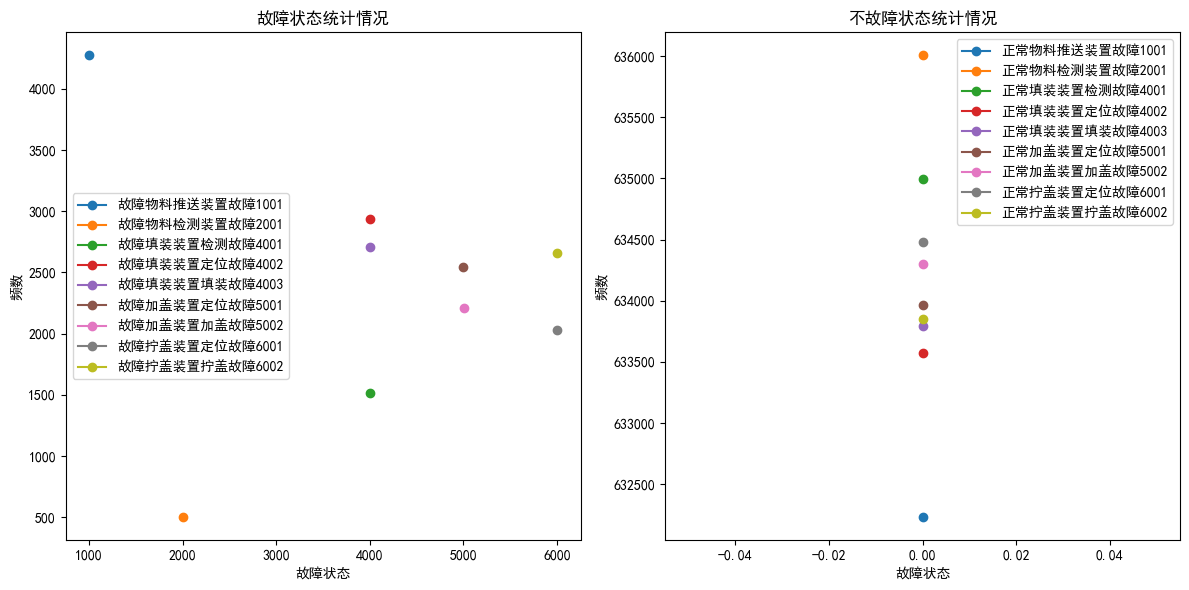

In [28]:
import matplotlib.pyplot as plt


# 创建画布
plt.figure(figsize=(12, 6))

# 绘制故障状态的折线图
plt.subplot(1, 2, 1)
for column in fault_columns:
    fault_counts = data[data[column] != 0][column].value_counts().sort_index()
    plt.plot(fault_counts.index, fault_counts.values, marker='o', label=f"故障{column}")
plt.title("故障状态统计情况")
plt.xlabel("故障状态")
plt.ylabel("频数")
plt.legend()

# 绘制不故障状态的折线图
plt.subplot(1, 2, 2)
for column in fault_columns:
    normal_counts = data[data[column] == 0][column].value_counts().sort_index()
    plt.plot(normal_counts.index, normal_counts.values, marker='o', label=f"正常{column}")
plt.title("不故障状态统计情况")
plt.xlabel("故障状态")
plt.ylabel("频数")
plt.legend()

plt.tight_layout()
plt.show()

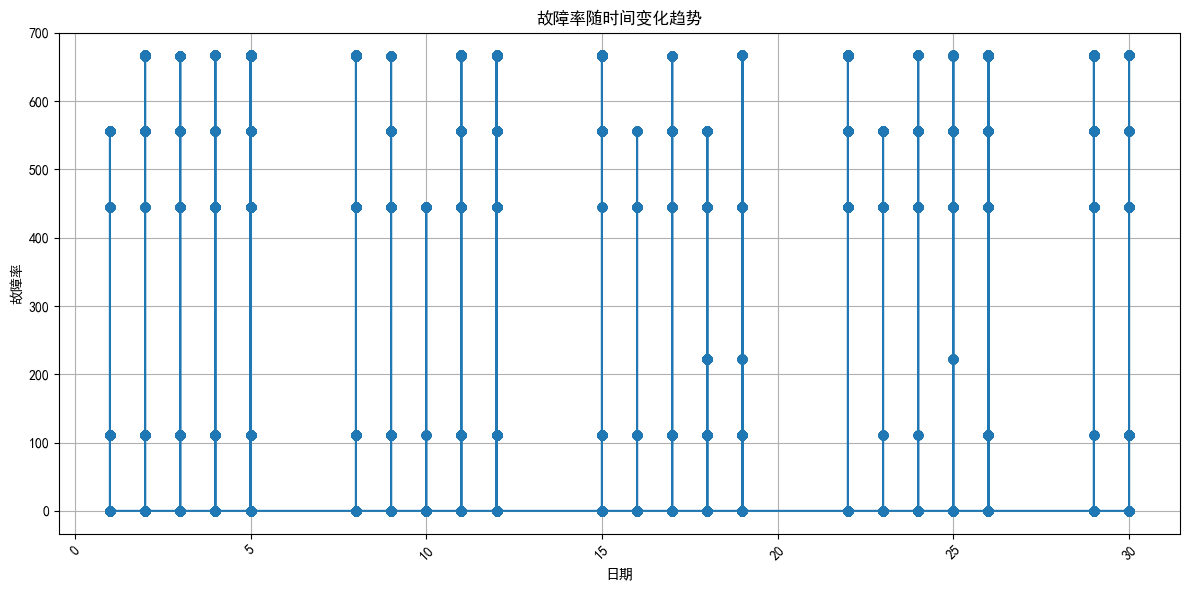

In [29]:
# 绘制故障率的时间序列图
plt.figure(figsize=(12, 6))
plt.plot(data['日期'], data['故障率'], marker='o', linestyle='-')
plt.title("故障率随时间变化趋势")
plt.xlabel("日期")
plt.ylabel("故障率")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

# 加载附件一中的数据
data1 = pd.read_csv('./Datasets/附件1/M101.csv')

# 假设使用之前建立的ARIMA模型进行故障检测，threshold是阈值
threshold = 0.5

# 储存报警信息的列表
alarms = []

# 针对每个故障编号进行处理
for fault_column in data1.columns[-9:]:
    # 提取日期、开始时间和持续时长信息
    fault_data = data1[['日期', '时间', fault_column]].rename(columns={fault_column: '持续时长'})
    
    # 假设对于每个故障编号，如果持续时长超过阈值，则判断为故障
    for _, row in fault_data.iterrows():
        if row['持续时长'] > threshold:
            alarms.append({'日期': row['日期'], '开始时间': row['时间'], '持续时长': row['持续时长'], '故障编号': fault_column})

# 将报警信息合并为一个DataFrame
alarms_df = pd.DataFrame(alarms)

alarms_df

,日期,开始时间,持续时长,故障编号
0,1,9759,1001,物料推送装置故障1001
1,1,9760,1001,物料推送装置故障1001
2,1,9761,1001,物料推送装置故障1001
3,1,9762,1001,物料推送装置故障1001
4,1,9763,1001,物料推送装置故障1001
...,...,...,...,...
21373,30,25320,6002,拧盖装置拧盖故障6002
21374,30,25321,6002,拧盖装置拧盖故障6002
21375,30,25322,6002,拧盖装置拧盖故障6002
21376,30,25323,6002,拧盖装置拧盖故障6002


D:\Software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


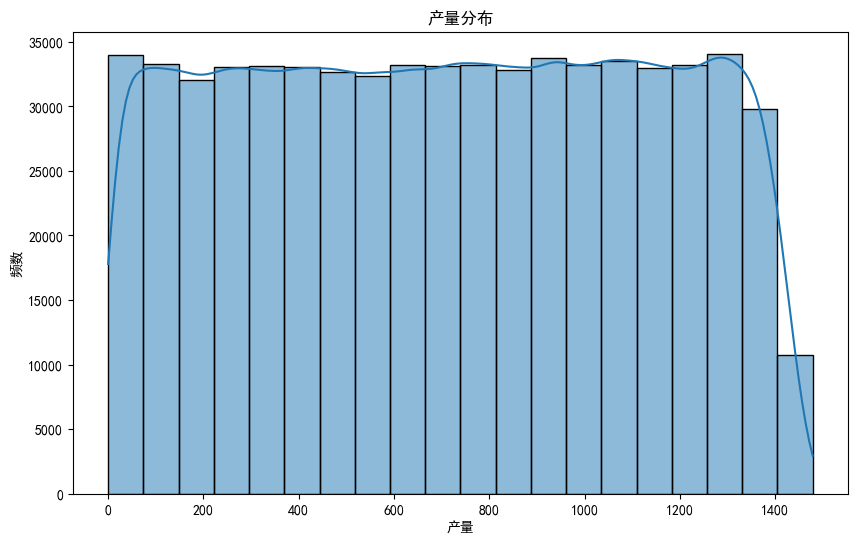

D:\Software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


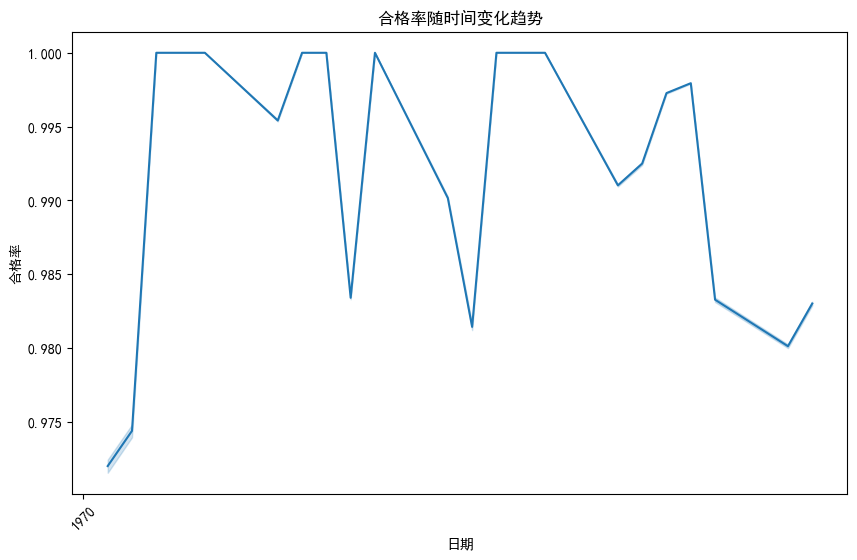

均方误差: 169878.08593114527


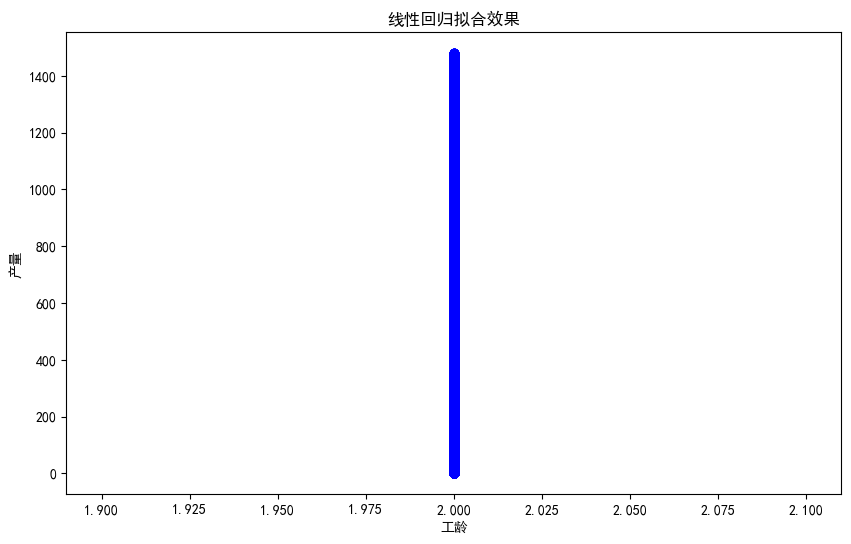

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 加载M301.csv数据和操作人员信息表
m301_data = pd.read_csv('./Datasets/附件3/M301.csv')
operator_info = pd.read_excel('./Datasets/附件3/操作人员信息表.xlsx')

# 合并操作人员信息到M301数据中
m301_data = pd.merge(m301_data, operator_info, on='生产线编号')

# 数据预处理
# 处理日期和时间字段
m301_data['日期'] = pd.to_datetime(m301_data['日期'])
m301_data['时间'] = pd.to_datetime(m301_data['时间'])

# 处理缺失值
m301_data.dropna(inplace=True)  # 删除含有缺失值的样本

# 特征工程
# 计算产量和合格率
m301_data['产量'] = m301_data['合格数'] + m301_data['不合格数']
m301_data['合格率'] = m301_data['合格数'] / m301_data['产量']

# 探索性数据分析（EDA）
# 产量分布可视化
plt.figure(figsize=(10, 6))
sns.histplot(m301_data['产量'], bins=20, kde=True)
plt.title('产量分布')
plt.xlabel('产量')
plt.ylabel('频数')
plt.show()

# 合格率随时间变化趋势可视化
plt.figure(figsize=(10, 6))
sns.lineplot(x='日期', y='合格率', data=m301_data)
plt.title('合格率随时间变化趋势')
plt.xlabel('日期')
plt.ylabel('合格率')
plt.xticks(rotation=45)
plt.show()

# 生产线、操作人员等因素与产量、合格率之间的关系分析
# 线性回归
X = m301_data[['工龄']]
y = m301_data['产量']

# 建立线性回归模型
model = LinearRegression()
model.fit(X, y)

# 模型评估
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print("均方误差:", mse)

# 可视化模型拟合效果
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red', linewidth=2)
plt.title('线性回归拟合效果')
plt.xlabel('工龄')
plt.ylabel('产量')
plt.show()

In [26]:
import pandas as pd
import numpy as np

# 读取问题三中的操作人员信息表
operator_info = pd.read_excel(r'./Datasets/附件3/操作人员信息表.xlsx')

# 根据问题三中的工龄比例计算各个工龄段的操作人员数量
total_operators = 100  # 假设总操作人员数为100
age_ratios = [0.2, 0.3, 0.5]  # 假设工龄比例为20%、30%、50%
num_ages = [int(total_operators * ratio) for ratio in age_ratios]

# 定义班次时间
shifts = ['早班', '中班', '晚班']
shift_hours = [(8, 16), (16, 24), (0, 8)]

# 定义排班规则
shift_length = 8  # 每个班次工作时长为8小时
rest_days = 2  # 连休2天
working_days = 7 - rest_days  # 每周工作天数

# 初始化排班结果表
schedule = pd.DataFrame(columns=['操作人员编号', '工龄', '生产线编号', '班次'])

# 遍历工龄段，为每个工龄段的操作人员制定排班方案
for age, num_age in enumerate(num_ages):
    # 生成工龄段的操作人员编号列表
    age_operators = operator_info[operator_info['工龄'] == age + 1]['操作人员编号'].tolist()
    
    # 如果该工龄段没有操作人员，则跳过
    if len(age_operators) == 0:
        continue
    
    # 计算该工龄段的操作人员平均每班数量
    avg_operators_per_shift = int(np.ceil(num_age / (len(shifts) * working_days)))
    
    # 根据平均每班数量，为每个操作人员分配班次
    for operator_idx in range(num_age):
        operator_id = age_operators[operator_idx % len(age_operators)]
        for shift_idx, shift in enumerate(shifts):
            start_hour, end_hour = shift_hours[shift_idx]
            schedule = pd.concat([schedule, pd.DataFrame({'操作人员编号': [operator_id],
                                                           '工龄': [age + 1],
                                                           '生产线编号': ['M301'],  # 假设所有操作人员都在M301生产线工作
                                                           '班次': [f"{shift} {start_hour}:00-{end_hour}:00"]})],
                                 ignore_index=True)

schedule

,操作人员编号,工龄,生产线编号,班次
0,A001,2,M301,早班 8:00-16:00
1,A001,2,M301,中班 16:00-24:00
2,A001,2,M301,晚班 0:00-8:00
3,A001,2,M301,早班 8:00-16:00
4,A001,2,M301,中班 16:00-24:00
...,...,...,...,...
85,A001,2,M301,中班 16:00-24:00
86,A001,2,M301,晚班 0:00-8:00
87,A001,2,M301,早班 8:00-16:00
88,A001,2,M301,中班 16:00-24:00
